## Importar librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

leer información y filtra columnas vacias de la tabla

In [2]:
df=pd.read_csv('data/Results_TTM.csv',sep=";",header=0)
df=df.drop(columns=["Step status","Current trend","Torque rate min","Torque rate max","Torque rate trend","CVILOGIX","Identifier6","Identifier7","Identifier8","Identifier9","Identifier10","Second transducer torque deviation","Second transducer angle deviation","Result type","Pulse counter","Angle offset","AO torque rate"])

C:\Users\guill\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (45,46,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Visualizar y corregir resultados

In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 47 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Result status              400000 non-null  object 
 1   Tool status                400000 non-null  object 
 2   Result number              400000 non-null  int64  
 3   Time result                400000 non-null  object 
 4   Pset ID                    399901 non-null  float64
 5   Step ID                    399901 non-null  float64
 6   Error Code                 22688 non-null   object 
 7   Stop source                400000 non-null  object 
 8   Torque min                 399901 non-null  float64
 9   Torque                     400000 non-null  float64
 10  Torque max                 399901 non-null  float64
 11  Torque trend               399712 non-null  object 
 12  Angle min                  399901 non-null  float64
 13  Angle                      40

se pueden quitar tambien Current min current max en A y en %, Torque rate, controlling transduce

In [4]:
df=df.drop(columns=["Controlling transducer","Current min (A)","Current max (A)","Current min (%)","Current max (%)","Current (%)","Torque rate","Current (A)"])

In [5]:
df.describe()

,Result number,Pset ID,Step ID,Torque min,Torque,Torque max,Angle min,Angle,Angle max,Controller serial no.,Tightening unit ID,Tool ID,Cable serial number
count,400000.000000,399901.000000,399901.000000,399901.000000,400000.000000,399901.000000,399901.000000,400000.000000,399901.000000,4.000000e+05,400000.0,400000.0,4.000000e+05
mean,416262.410105,12.504357,1.037939,21.408476,23.753086,26.957885,5.379175,86.366365,1196.548038,2.144767e+10,1.0,1.0,2.916281e+10
std,215364.527574,18.536924,0.191050,7.708038,9.201438,9.537860,66.870590,319.555730,1347.550850,7.299711e+09,0.0,0.0,4.542284e+07
min,2531.000000,1.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1.201100e+10,1.0,1.0,2.908110e+10
25%,284675.750000,3.000000,1.000000,20.000000,20.346000,24.000000,0.000000,21.143000,110.000000,1.201100e+10,1.0,1.0,2.912120e+10
50%,383139.500000,10.000000,1.000000,20.000000,22.218000,24.000000,5.000000,30.378000,220.000000,2.704120e+10,1.0,1.0,2.916140e+10
75%,600896.250000,15.000000,1.000000,30.000000,30.320000,40.000000,5.000000,45.738000,3000.000000,2.714160e+10,1.0,1.0,2.920160e+10
max,801095.000000,250.000000,2.000000,40.000000,56.069000,45.000000,4200.000000,5167.900000,6000.000000,2.723180e+10,1.0,1.0,2.922180e+10


Por mania: quitar los espacios de los nombres de las columnas:

In [6]:
df=df.rename(columns={"Result number":"Result_number","Pset ID":"Pset_ID","Step ID":"Step_ID","Torque min":"Torque_min","Torque max":"Torque_max","Angle min":"Angle_min","Angle max":"Angle_max","Controller serial no.":"Controller_serial_no.","Pset name":"Pset_name",'Controller name':'Controller_name','Error code':'Error_code','Result_status':'Result_status'})

Quitamos los resultados de PSets que no nos interesan (los que contienen "Poka" y "Unscrew")

In [7]:
df = df[~df["Pset_name"].str.contains("Poka",na=False)]

Cambio la columna fecha a datetime

In [8]:
df.astype({'Time result': 'datetime64[ns, US/Eastern]'}).dtypes


Result status                                    object
Tool status                                      object
Result_number                                     int64
Time result                  datetime64[ns, US/Eastern]
Pset_ID                                         float64
Step_ID                                         float64
Error Code                                       object
Stop source                                      object
Torque_min                                      float64
Torque                                          float64
Torque_max                                      float64
Torque trend                                     object
Angle_min                                       float64
Angle                                           float64
Angle_max                                       float64
Angle trend                                      object
Spindle comment                                  object
Controller_name                                 

Vamos a analizar por separado los resultados buenos y los no buenos:

In [9]:
df_nok=df[df['Result status'].str.contains("NOK")]

Tambien vamos a crear la tabla de resultados ok para otros analisis

In [10]:
df_ok=df[df['Result status'].str.contains("OK")]

Vamos a graficar el número de pares malos por pset para ver cuales son los peores

In [11]:
topnok=df_nok.groupby(by='Pset_name').count()

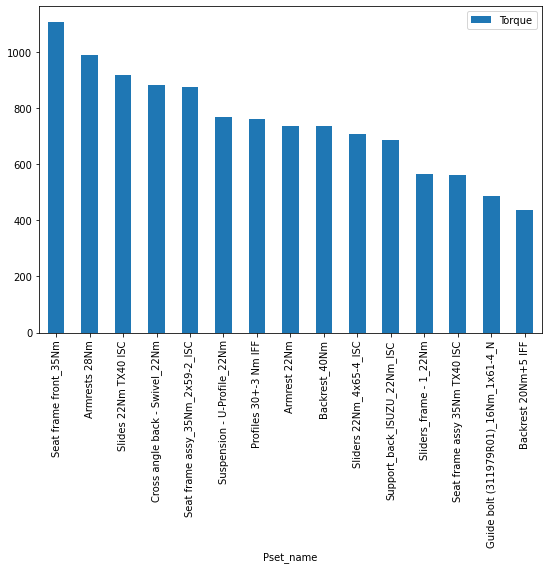

In [12]:
fig, ax = plt.subplots(figsize=(9,6))
top15nok = topnok[['Torque']].nlargest(15,'Torque').plot(kind='bar', ax=ax)

Vamos a hechar un vistazo a porque fallan estos pares, existe ya una columna con 'Error code' informacion al respecto

In [13]:
toperror=df_nok.groupby(['Error Code','Pset_name']).count()
print(toperror[['Torque','Angle']].nlargest(15,'Torque'))

                                                                           Torque  \
Error Code                           Pset_name                                      
Other spindle stop                   Armrests 28Nm                            817   
Start signal or tool validation lost Slides 22Nm TX40 ISC                     609   
Other spindle stop                   Profiles 30+-3 Nm IFF                    599   
Start signal or tool validation lost Armrest 22Nm                             599   
Other spindle stop                   Suspension - U-Profile_22Nm              576   
                                     Seat frame assy_35Nm_2x59-2_ISC          573   
                                     Seat frame front_35Nm                    562   
Start signal or tool validation lost Seat frame front_35Nm                    547   
                                     Seat frame assy 35Nm TX40 ISC            542   
Other spindle stop                   Support_back_ISUZU_22Nm_ISC 

Vamos a plotearlo

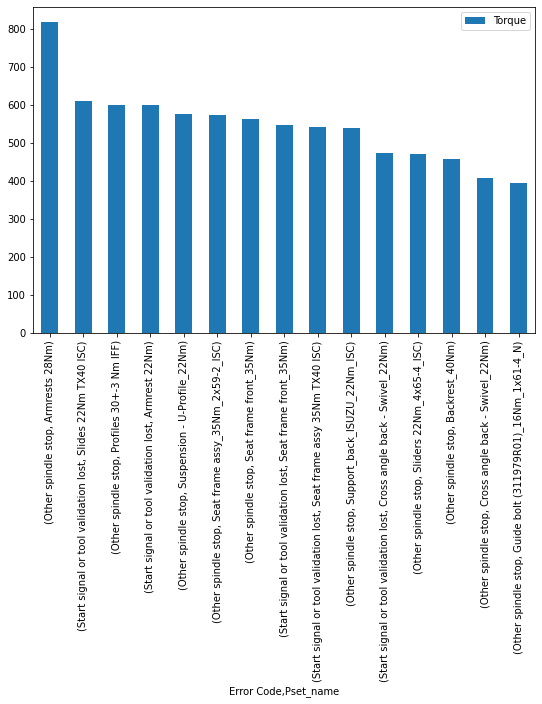

In [14]:
fig, ax = plt.subplots(figsize=(9,6))
top15error = toperror[['Torque']].nlargest(15,'Torque').plot(kind='bar', ax=ax)

Esto nos da otro punto de vista, ahora el fallo top parece ser que los reposabrazos fallan por angulo *(TODO:revisar los valores de angulo de los errores e other spindle stop)*
Vamos a crear otra columna calculando los Angle y Torque objetivo a partir de 'Angle max', 'Angle min','Torque max','Torque min'

In [15]:
df_nok['Torque_target']=df.Torque_min+((df.Torque_max-df.Torque_min)/2)

<ipython-input-15-badf3d49c09f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nok['Torque_target']=df.Torque_min+((df.Torque_max-df.Torque_min)/2)


In [16]:
print(df_nok['Torque_target'])

34        35.0
74        35.0
125       35.0
136       35.0
139       35.0
          ... 
399898    35.0
399958    22.0
399966    22.0
399967    22.0
399969    22.0
Name: Torque_target, Length: 21511, dtype: float64


hacemos los mismo para los angulos

In [17]:
df_nok['Angle_target']=df.Angle_min+((df.Angle_max-df.Angle_min)/2)
print(df_nok['Angle_target'])

34        1500.0
74          66.0
125         66.0
136       1500.0
139       1500.0
           ...  
399898     100.0
399958      47.5
399966      47.5
399967      47.5
399969      47.5
Name: Angle_target, Length: 21511, dtype: float64
<ipython-input-17-cac56a899b3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nok['Angle_target']=df.Angle_min+((df.Angle_max-df.Angle_min)/2)


veamos ahora los targets por pset:


In [18]:
df_nok_mean=df_nok.groupby(by='Pset_name').mean()

In [19]:
print(df_nok_mean[['Torque','Torque_target','Angle','Angle_target']])

                                   Torque  Torque_target        Angle  \
Pset_name                                                               
3rd Point belt 35+_-5Nm ISC     16.069429          35.00    39.148643   
3rd Point belt_37.5Nm           22.426403          37.50    77.490448   
Adaptor 22Nm TX40 ISC            8.722526          22.00    11.784474   
Adaptor plate 22Nm TX40 ISC x6  13.494123          22.00    56.318070   
Air spring 5Nm HEX6 N            2.462111           5.00   257.147926   
...                                   ...            ...          ...   
Trail_22Nm_IFF                  13.583500          22.00   299.925529   
Trailer screw 20Nm               3.314719          20.00    13.039311   
Transport tray_5Nm               1.176042           2.25  2321.477565   
Unscrew                          3.099869           2.50  1233.888263   
Unscrew suspension               4.022812          20.00  1303.220656   

                                Angle_target  
Pse

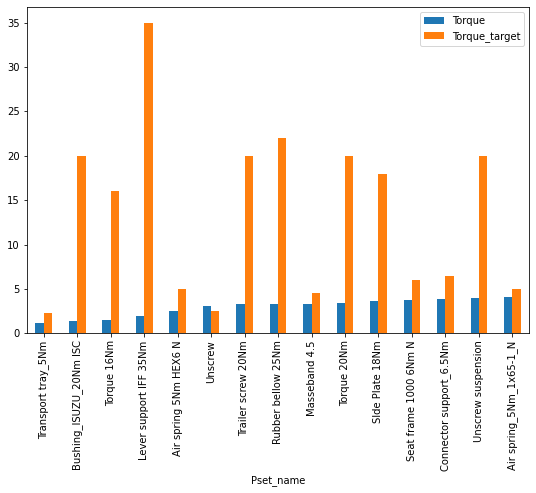

In [20]:
fig, ax = plt.subplots(figsize=(9,6))
df_nok_mean_g=df_nok_mean[['Torque','Torque_target']].nsmallest(15,'Torque').plot(kind='bar', ax=ax)

In [21]:
df_nok_mean[['Torque_min','Torque','Torque_max','Torque_target','Angle_min','Angle','Angle_max','Angle_target']].nsmallest(20,'Angle_target')

,Torque_min,Torque,Torque_max,Torque_target,Angle_min,Angle,Angle_max,Angle_target
Pset_name,,,,,,,,
Embocar Profiles 30Nm ISC,0.000000,6.107375,26.000000,13.000000,0.0,283.725625,0.000000,0.000000
Torque 21Nm,11.428571,13.600714,21.142857,16.285714,0.0,234.083714,57.142857,28.571429
Belt in backrest frame 35Nm TX45 ISC,16.996198,11.557859,40.000000,28.498099,0.0,260.752920,62.319392,31.159696
Backrest_(39704R01)_35Nm_2x61-1_ISC,30.000000,20.062317,40.000000,35.000000,2.0,70.907179,80.000000,41.000000
Belt reel support_20Nm_3x64-3_,18.000000,12.676473,22.000000,20.000000,5.0,56.002795,80.000000,42.500000
Belt reel (36691B02)_37.5Nm_1x61-2_ISC,35.000000,25.862416,40.000000,37.500000,5.0,55.373119,83.000000,44.000000
Bearing inclination cap_22Nm_2x59-1_ISC,20.000000,20.386351,24.000000,22.000000,5.0,28.462225,90.000000,47.500000
Belt retaining platte_22Nm,20.000000,21.762156,24.000000,22.000000,5.0,38.182781,90.000000,47.500000
Inner carrier_22Nm_2x59-3_ISC,20.000000,17.057504,24.000000,22.000000,5.0,34.620198,90.000000,47.500000


Comprando la tabla de abajo sacada antes en grafica con la de arriba podemos ver cuales de los tops en fallos pueden tener su causa raiz en un limite superior de angulo muy bajo.

In [22]:
toperror[['Torque']].nlargest(20,'Torque')

Torque
Error Code                           Pset_name                                   
Other spindle stop                   Armrests 28Nm                            817
Start signal or tool validation lost Slides 22Nm TX40 ISC                     609
Other spindle stop                   Profiles 30+-3 Nm IFF                    599
Start signal or tool validation lost Armrest 22Nm                             599
Other spindle stop                   Suspension - U-Profile_22Nm              576
                                     Seat frame assy_35Nm_2x59-2_ISC          573
                                     Seat frame front_35Nm                    562
Start signal or tool validation lost Seat frame front_35Nm                    547
                                     Seat frame assy 35Nm TX40 ISC            542
Other spindle stop                   Support_back_ISUZU_22Nm_ISC              539
Start signal or tool validation lost Cross angle back - Swivel_22Nm           474
Other spindle stop                   Sliders 22Nm_4x65-4_ISC                  470
                                     Backrest_40Nm                            459
                                     Cross angle back - Swivel_22Nm           407
                                     Guide bolt (311979R01)_16Nm_1x61-4_N     394
                                     Sliders_frame - 1_22Nm                   393
                                     Backrest 20Nm+5 IFF                      330
Start signal or tool validation lost Seat frame assy_35Nm_2x59-2_ISC          304
Other spindle stop                   Slides 22Nm TX40 ISC                     289
Start signal or tool validation lost Backrest_40Nm                            279

**Conclusiones:**

1. Torque 21 Nm está mal configurado, se pasa de angulo muchisimo (¿Se usa en procesos productivos?).

2. Support_back_ISUZU_22Nm_ISC se tiene que revisar la media de angulos está en 89 y el maximo es 90.

3. Sliders_frame - 1_22Nm y Sliders_frame - 2_22Nm están tambien cerca o por encima del limite superior.

4. Por ultimo y aunque no aparezca en la lista de tops Belt in backrest frame 35Nm TX45 ISC tambien está muy por encima la media del limite superior de ángulo.

Vamos a revisar ahora con la tabla anterior cambiando el orden a las que mayor angulo medio tienen:

In [23]:
df_nok_mean[['Torque_min','Torque','Torque_max','Torque_target','Angle_min','Angle','Angle_max','Angle_target']].loc[df_nok_mean['Angle']>df_nok_mean['Angle_max']]

,Torque_min,Torque,Torque_max,Torque_target,Angle_min,Angle,Angle_max,Angle_target
Pset_name,,,,,,,,
Backrest 20Nm ISC_A_BAU,20.000000,14.908000,25.000000,22.500000,5.0,1000.190000,999.000000,502.000000
Backrest and armrests 22Nm,20.000000,16.597000,24.000000,22.000000,2.0,1000.150000,999.000000,500.500000
Belt in backrest frame 25Nm TX45 ISC,9.577465,13.962324,35.211268,22.394366,0.0,321.160423,239.436620,119.718310
Belt in backrest frame 35Nm TX45 ISC,16.996198,11.557859,40.000000,28.498099,0.0,260.752920,62.319392,31.159696
Belt retainning platte 30Nm IFF,3.000000,7.111793,35.000000,19.000000,0.0,735.052448,206.896552,103.448276
Embocar Profiles 30Nm ISC,0.000000,6.107375,26.000000,13.000000,0.0,283.725625,0.000000,0.000000
Sliders_frame - 2_22Nm,20.000000,17.752695,24.000000,22.000000,5.0,101.013873,90.000000,47.500000
Torque 21Nm,11.428571,13.600714,21.142857,16.285714,0.0,234.083714,57.142857,28.571429
Torque 5Nm,3.000000,4.308125,7.000000,5.000000,0.0,212.385125,165.000000,82.500000


De la tabla anterior todos para revisar, ya que vemos que sus medias están todas por encima o muy por encima de del angulo maximo.

1. Voy a crear una tabla que contenga el Pset? torque min, torque max, torque, angle min, angle max, angle.

2. voy a crear otra que contenga el resultado ok/nok as 0/1

3. voy a entrenar un modelo de regresion logistica para predecir con los campos de arriba si un par va a dar bueno o malo

In [24]:
#primero voy a crear la tabla incluyendo un campo result 0/1
df['Resultbin']=df['Result status']=='OK'
print (df['Resultbin'].head())

0    True
1    True
2    True
3    True
4    True
Name: Resultbin, dtype: bool


In [30]:
df.tail()

,Result status,Tool status,Result_number,Time result,Pset_ID,Step_ID,Error Code,Stop source,Torque_min,Torque,...,Batch,Identifier1,Identifier2,Identifier3,Identifier4,Identifier5,Torque (monitoring),Angle (monitoring),Angle Threshold,Resultbin
399995,OK,OK,286841,2020-09-29 18:51:08.0,5.0,1.0,NaN,Target reached,20.0,22.422,...,2(2),#######89161-05/00,5.52002e+14,2362,NaN,NaN,---,---,7.0,True
399996,OK,OK,286840,2020-09-29 18:51:03.0,5.0,1.0,NaN,Target reached,20.0,22.154,...,1(2),#######89161-05/00,5.52002e+14,2362,NaN,NaN,---,---,7.0,True
399997,OK,OK,760759,2020-09-29 18:50:45.0,16.0,1.0,NaN,Target reached,8.0,10.049,...,1(0),NaN,NaN,NaN,NaN,NaN,---,---,4.0,True
399998,OK,OK,487287,2020-09-29 18:50:40.0,21.0,1.0,NaN,Target reached,3.5,4.543,...,1(0),NaN,NaN,NaN,NaN,NaN,---,---,3.7,True
399999,OK,OK,356116,2020-09-29 18:50:37.0,18.0,1.0,NaN,Target reached,35.0,37.966,...,1(0),NaN,NaN,NaN,NaN,NaN,---,---,19.0,True


In [25]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(solver='liblinear')

In [26]:
dfX=df[['Torque_min','Torque','Torque_max','Angle_min','Angle','Angle_max','Resultbin']].dropna()
dfX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398844 entries, 0 to 399999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Torque_min  398844 non-null  float64
 1   Torque      398844 non-null  float64
 2   Torque_max  398844 non-null  float64
 3   Angle_min   398844 non-null  float64
 4   Angle       398844 non-null  float64
 5   Angle_max   398844 non-null  float64
 6   Resultbin   398844 non-null  bool   
dtypes: bool(1), float64(6)
memory usage: 21.7 MB


In [27]:
X=dfX[['Torque_min','Torque','Torque_max','Angle_min','Angle','Angle_max',]].values
y=dfX['Resultbin'].values

In [28]:
model.fit(X,y)
print(model.coef_,model.intercept_)

[[-6.61546129e-01  7.15063086e-01 -6.99185839e-02 -9.85435774e-04
  -6.64528885e-05  2.51940359e-04]] [2.4962245]


In [29]:
y_pred=model.predict(X)
print((y==y_pred).sum())
print(model.score(X,y))

390271
0.9785053805497889


Vamos a codificar los valores interesantes de Psetname = Pset, Identifier1= Modelo, Identifier3=Trabajador para ello utilizo LabelEncoder de sklearn

In [41]:
from sklearn.preprocessing import   LabelEncoder
enc=LabelEncoder()
dfX_=df[['Torque_min','Torque_max','Angle_min','Angle_max','Pset_name',	'Identifier1','Identifier3','Resultbin']].dropna()
dfX_['Identifier3'].astype('str')
dfX_['Pset_name_cat'] = enc.fit_transform(dfX_['Pset_name'])
dfX_['Modelo'] = enc.fit_transform(dfX_['Identifier1'])
#dfX_['Identifier3_cat'] = enc.fit_transform(dfX_['Identifier3']) => NEcesito importar de SQL la tabla de trabajadores y mergearla con pandas a esta.
dfX_ #muestro por pantalla el Df para comprobar el resultado de las operaciones

,Torque_min,Torque_max,Angle_min,Angle_max,Pset_name,Identifier1,Identifier3,Resultbin,Pset_name_cat,Modelo
10,14.0,18.0,0.0,3000.0,Guide bolt 16Nm TX40 N,######814821-01/00,2356,True,70,115
12,30.0,40.0,0.0,3000.0,Belt 3rd point 35Nm TX45 ISC,######814821-01/00,2356,True,24,115
13,30.0,40.0,0.0,3000.0,Belt reel 35Nm TX45 ISC,######814821-01/00,2356,True,36,115
17,7.0,13.0,0.0,3000.0,Bearing bolt 10Nm TX30 N,######814821-01/00,2369,True,19,115
18,20.0,22.0,0.0,4000.0,Inner carrier 21Nm HEX8 ISC,552002110602000,2401,True,73,312
...,...,...,...,...,...,...,...,...,...,...
399990,20.0,30.0,0.0,500.0,Belt in backrest frame 25Nm TX45 ISC,######815202-02/00,2395,True,29,120
399991,30.0,40.0,0.0,3000.0,Seat frame assy 35Nm TX40 ISC,#######89161-05/00,2362,True,90,41
399994,30.0,40.0,0.0,350.0,Belt buckle 35Nm TX45 ISC,#######89161-05/00,2455,True,27,41
399995,20.0,24.0,0.0,220.0,Bearing inclination cap 22Nm HEX8 ISC,#######89161-05/00,2362,True,21,41


In [44]:
X=dfX_[['Torque_min','Torque_max','Angle_min','Angle_max','Pset_name_cat','Modelo']].values
y=dfX_[['Resultbin']]

,Torque_min,Torque_max,Angle_min,Angle_max,Pset_name,Identifier1,Identifier3,Resultbin,Pset_name_cat,Modelo
10,14.0,18.0,0.0,3000.0,Guide bolt 16Nm TX40 N,######814821-01/00,2356,True,70,115
12,30.0,40.0,0.0,3000.0,Belt 3rd point 35Nm TX45 ISC,######814821-01/00,2356,True,24,115
13,30.0,40.0,0.0,3000.0,Belt reel 35Nm TX45 ISC,######814821-01/00,2356,True,36,115
17,7.0,13.0,0.0,3000.0,Bearing bolt 10Nm TX30 N,######814821-01/00,2369,True,19,115
18,20.0,22.0,0.0,4000.0,Inner carrier 21Nm HEX8 ISC,552002110602000,2401,True,73,312
...,...,...,...,...,...,...,...,...,...,...
399990,20.0,30.0,0.0,500.0,Belt in backrest frame 25Nm TX45 ISC,######815202-02/00,2395,True,29,120
399991,30.0,40.0,0.0,3000.0,Seat frame assy 35Nm TX40 ISC,#######89161-05/00,2362,True,90,41
399994,30.0,40.0,0.0,350.0,Belt buckle 35Nm TX45 ISC,#######89161-05/00,2455,True,27,41
399995,20.0,24.0,0.0,220.0,Bearing inclination cap 22Nm HEX8 ISC,#######89161-05/00,2362,True,21,41


In [43]:
model.fit(X,y)
print(model.coef_,model.intercept_)
print(model.score(X,y))

C:\Users\guill\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[[ 0.06222346 -0.04842636 -0.12692669  0.00026643  0.00462175 -0.0042725 ]] [2.61835633]
0.9453699239975956


Pruebo a predecir un valor de X

In [45]:
model.predict([X[10]])

array([ True])

Observo el dato que le he pasado

In [46]:
print(X[0])

[  14.   18.    0. 3000.   70.  115.]


Creo un dataframe con resultados que creo que serán NOK para comprobar que tan bueno es el modelo.

In [54]:
fallos = pd.DataFrame({"Torque_min": [2, 3, 30],
                        "Torque_max": [1, 30, 15],
                        "Angle_min": [0,500,5000],
                        "Angle_max":[10,500,5000],
                        "Pset_name_cat":[70,29,27],
                        "Modelo":[1,2,3]})

In [63]:
X_=fallos.values

Repito la operacion anterior pero con los datos del nuevo DataFrame

In [64]:
X_[0]

array([ 2,  1,  0, 10, 70,  1], dtype=int64)

In [69]:
print(fallos.iloc[[0]])
print(model.predict([X_[0]]))
print(fallos.iloc[[1]])
print(model.predict([X_[1]]))
print(fallos.iloc[[2]])
print(model.predict([X_[2]]))

   Torque_min  Torque_max  Angle_min  Angle_max  Pset_name_cat  Modelo
0           2           1          0         10             70       1
[ True]
   Torque_min  Torque_max  Angle_min  Angle_max  Pset_name_cat  Modelo
1           3          30        500        500             29       2
[False]
   Torque_min  Torque_max  Angle_min  Angle_max  Pset_name_cat  Modelo
2          30          15       5000       5000             27       3
[False]
